This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# How to use wradlib's ipol module for interpolation tasks?

In [1]:
import wradlib.ipol as ipol
from wradlib.util import get_wradlib_data_file
from wradlib.vis import plot_ppi
import numpy as np
import matplotlib.pyplot as pl
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

### 1-dimensional example

Includes Nearest Neighbours, Inverse Distance Weighting, and Ordinary Kriging.

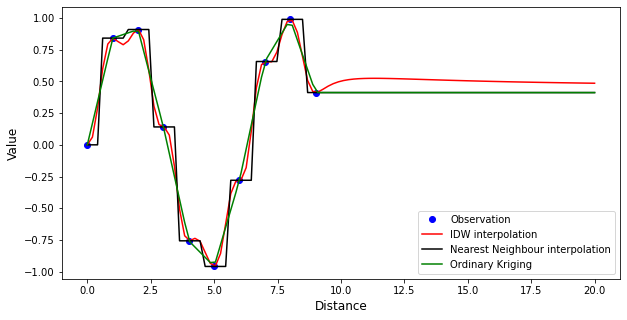

In [2]:
# Synthetic observations
xsrc = np.arange(10)[:, None]
vals = np.sin(xsrc).ravel()

# Define target coordinates
xtrg = np.linspace(0, 20, 100)[:, None]

# Set up interpolation objects
#   IDW
idw = ipol.Idw(xsrc, xtrg)
#   Nearest Neighbours
nn = ipol.Nearest(xsrc, xtrg)
#   Linear
ok = ipol.OrdinaryKriging(xsrc, xtrg)

# Plot results
pl.figure(figsize=(10,5))
pl.plot(xsrc.ravel(), vals, 'bo', label="Observation")
pl.plot(xtrg.ravel(), idw(vals), 'r-', label="IDW interpolation")
pl.plot(xtrg.ravel(), nn(vals), 'k-', label="Nearest Neighbour interpolation")
pl.plot(xtrg.ravel(), ok(vals), 'g-', label="Ordinary Kriging")
pl.xlabel("Distance", fontsize="large")
pl.ylabel("Value", fontsize="large")
pl.legend(loc="lower right")

### 2-dimensional example

Includes Nearest Neighbours, Inverse Distance Weighting, Linear Interpolation, and Ordinary Kriging.

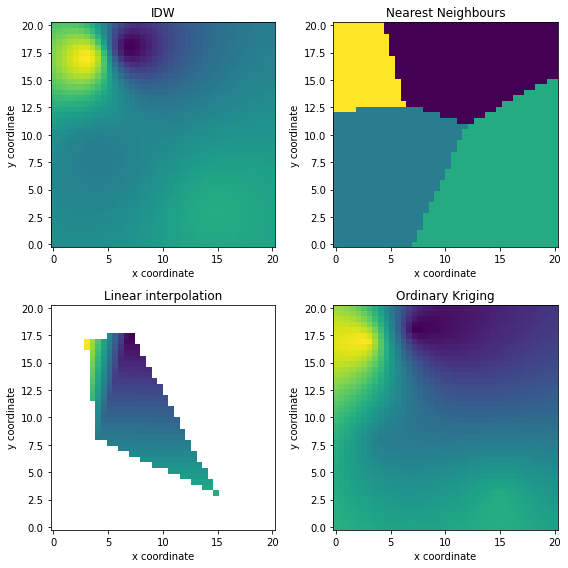

In [3]:
# Synthetic observations and source coordinates
src = np.vstack( (np.array([4, 7, 3, 15]), np.array([8, 18, 17, 3]))).transpose()
np.random.seed(1319622840)
vals = np.random.uniform(size=len(src))

# Target coordinates
xtrg = np.linspace(0, 20, 40)
ytrg = np.linspace(0, 20, 40)
trg = np.meshgrid(xtrg, ytrg)
trg = np.vstack( (trg[0].ravel(), trg[1].ravel()) ).T

# Interpolation objects
idw = ipol.Idw(src, trg)
nn = ipol.Nearest(src, trg)
linear = ipol.Linear(src, trg)
ok = ipol.OrdinaryKriging(src, trg)

# Subplot layout
def gridplot(interpolated, title=""):
    pm = ax.pcolormesh(xtrg, ytrg, interpolated.reshape( (len(xtrg), len(ytrg)) ) )
    pl.axis("tight")
    ax.scatter(src[:, 0], src[:, 1], facecolor="None", s=50, marker='s')
    pl.title(title)
    pl.xlabel("x coordinate")
    pl.ylabel("y coordinate")

# Plot results
fig = pl.figure(figsize=(8,8))
ax = fig.add_subplot(221, aspect="equal")
gridplot(idw(vals), "IDW")
ax = fig.add_subplot(222, aspect="equal")
gridplot(nn(vals), "Nearest Neighbours")
ax = fig.add_subplot(223, aspect="equal")
gridplot(np.ma.masked_invalid(linear(vals)), "Linear interpolation")
ax = fig.add_subplot(224, aspect="equal")
gridplot(ok(vals), "Ordinary Kriging")
pl.tight_layout()

### Using the convenience function ipol.interpolation in order to deal with missing values

**(1)** Exemplified for one dimension in space and two dimensions of the source value array (could e.g. be two time steps).

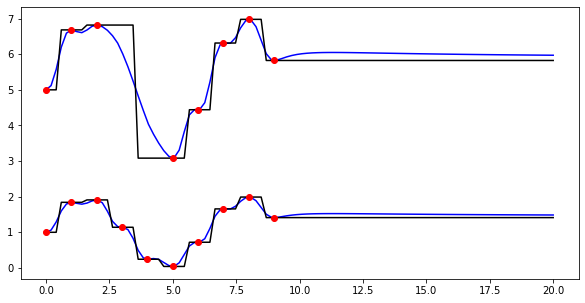

In [4]:
# Synthetic observations (e.g. two time steps)
src = np.arange(10)[:, None]
vals = np.hstack((1.+np.sin(src), 5. + 2.*np.sin(src)))
# Target coordinates
trg = np.linspace(0, 20, 100)[:, None]
# Here we introduce missing values in the second dimension of the source value array
vals[3:5, 1] = np.nan
# interpolation using the convenience function "interpolate"
idw_result = ipol.interpolate(src, trg, vals, ipol.Idw, nnearest=4)
nn_result = ipol.interpolate(src, trg, vals, ipol.Nearest)
# Plot results
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)
pl1 = ax.plot(trg, idw_result, 'b-', label="IDW")
pl2 = ax.plot(trg, nn_result, 'k-', label="Nearest Neighbour")
pl3 = ax.plot(src, vals, 'ro', label="Observations")

**(2)** Exemplified for two dimensions in space and two dimensions of the source value array (e.g. time steps), containing also NaN values (here we only use IDW interpolation)

In [5]:
# Just a helper function for repeated subplots
def plotall(ax, trgx, trgy, src, interp, pts, title, vmin, vmax):
    ix = np.where(np.isfinite(pts))
    ax.pcolormesh(trgx, trgy, interp.reshape( (len(trgx),len(trgy) ) ), vmin=vmin, vmax=vmax )
    ax.scatter(src[ix, 0].ravel(), src[ix, 1].ravel(), c=pts.ravel()[ix], s=20, marker='s',
               vmin=vmin, vmax=vmax)
    ax.set_title(title)
    pl.axis("tight")

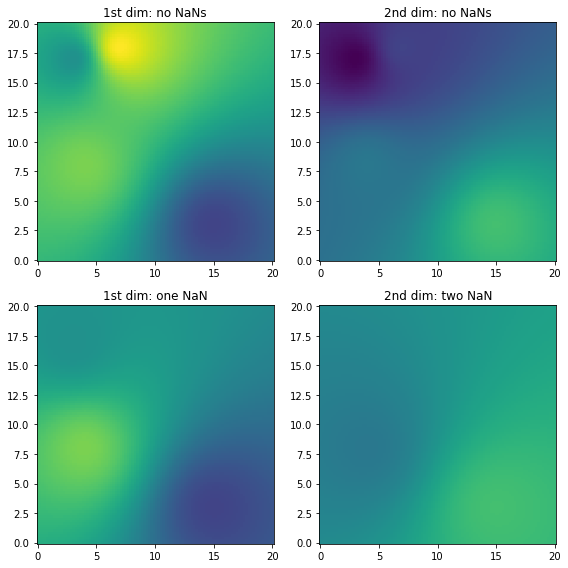

In [6]:
# Synthetic observations
src = np.vstack( (np.array([4, 7, 3, 15]), np.array([8, 18, 17, 3])) ).T
np.random.seed(1319622840 + 1)
vals = np.round(np.random.uniform(size=(len(src), 2)), 1)

# Target coordinates
trgx = np.linspace(0, 20, 100)
trgy = np.linspace(0, 20, 100)
trg = np.meshgrid(trgx, trgy)
trg = np.vstack((trg[0].ravel(), trg[1].ravel())).transpose()

result = ipol.interpolate(src, trg, vals, ipol.Idw, nnearest=4)

# Now introduce NaNs in the observations
vals_with_nan = vals.copy()
vals_with_nan[1, 0] = np.nan
vals_with_nan[1:3, 1] = np.nan
result_with_nan = ipol.interpolate(src, trg, vals_with_nan, ipol.Idw, nnearest=4)
vmin = np.concatenate((vals.ravel(), result.ravel())).min()
vmax = np.concatenate((vals.ravel(), result.ravel())).max()

fig = pl.figure(figsize=(8,8))
ax = fig.add_subplot(221)
plotall(ax, trgx, trgy, src, result[:, 0], vals[:, 0], '1st dim: no NaNs', vmin, vmax)
ax = fig.add_subplot(222)
plotall(ax, trgx, trgy, src, result[:, 1], vals[:, 1], '2nd dim: no NaNs', vmin, vmax)
ax = fig.add_subplot(223)
plotall(ax, trgx, trgy, src, result_with_nan[:, 0], vals_with_nan[:, 0], '1st dim: one NaN', vmin, vmax)
ax = fig.add_subplot(224)
plotall(ax, trgx, trgy, src, result_with_nan[:, 1], vals_with_nan[:, 1], '2nd dim: two NaN', vmin, vmax)
pl.tight_layout()

### How to use interpolation for gridding data in polar coordinates?

Read polar coordinates and corresponding rainfall intensity from file

In [7]:
filename = get_wradlib_data_file('misc/bin_coords_tur.gz')
src = np.loadtxt(filename)

filename = get_wradlib_data_file('misc/polar_R_tur.gz')
vals = np.loadtxt(filename)

In [8]:
src.shape

(46080, 2)

Define target grid coordinates

In [9]:
xtrg = np.linspace(src[:,0].min(), src[:,0].max(), 200)
ytrg = np.linspace(src[:,1].min(), src[:,1].max(), 200)
trg = np.meshgrid(xtrg, ytrg)
trg = np.vstack((trg[0].ravel(), trg[1].ravel())).T

Linear Interpolation

In [10]:
ip_lin = ipol.Linear(src, trg)
result_lin = ip_lin(vals.ravel(), fill_value=np.nan)

IDW interpolation

In [11]:
ip_near = ipol.Nearest(src, trg)
maxdist = trg[1,0] - trg[0,0]
result_near = ip_near(vals.ravel(), maxdist=maxdist)

Plot results

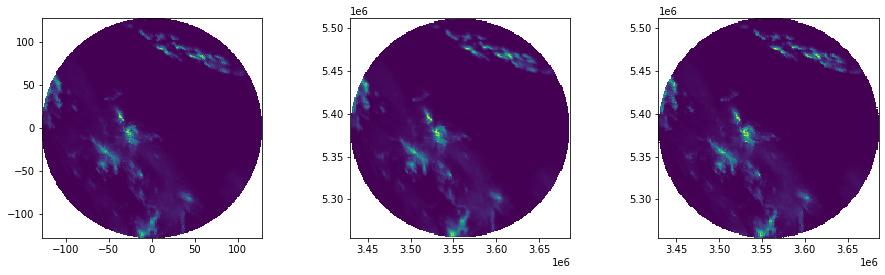

In [12]:
fig = pl.figure(figsize=(15, 6))
fig.subplots_adjust(wspace=0.4)
ax = fig.add_subplot(131, aspect="equal")
plot_ppi(vals, ax=ax)
ax = fig.add_subplot(132, aspect="equal")
pl.pcolormesh(xtrg, ytrg, result_lin.reshape( (len(xtrg), len(ytrg)) ) )
ax = fig.add_subplot(133, aspect="equal")
pl.pcolormesh(xtrg, ytrg, result_near.reshape( (len(xtrg), len(ytrg)) ) )